In [10]:
import os
from matplotlib import pyplot as plt
import pandas as pd

from loguru import logger

from nviro_fetch.auth import authenticate

logger.enable("nviro_fetch")

## Setup


In [7]:
from devices import check_and_load_devices
from env import env_global
from readings import (
    export_readings,
    import_readings,
    calculate_time_difference,
)

start_date = env_global("start_date")
end_date = env_global("end_date")
path_data = env_global("path_data")
path_readings = f"{path_data}/readings"
devices = check_and_load_devices()

In [ ]:
data_list = []
devices_inside = [device for device in devices if device["device_name"] != "Willow Creek Weather"]
for device in devices_inside:
    logger.info(f"Processing device {device['device_name']}")
    df = import_readings(
        device["device_name"].replace(" ", "_").lower(), type="cleaned"
    )
    data_list.append(df)


2025-06-17 13:44:20.006 | INFO     | __main__:<module>:4 - Processing device Aquanet Light Sensor
2025-06-17 13:44:20.007 | INFO     | readings:import_readings:71 - Importing readings from folder: /Users/wspamer/Dev/python/projects/ccr-system/nvirosense/data/readings/cleaned
2025-06-17 13:44:20.008 | INFO     | files:find_file:84 - Found file: aquanet_light_sensor_2025-06-11.csv for device: aquanet_light_sensor
2025-06-17 13:44:20.008 | INFO     | readings:import_readings:75 - Importing readings from file: aquanet_light_sensor_2025-06-11.csv
2025-06-17 13:44:20.017 | INFO     | readings:import_readings:85 - Readings imported successfully from /Users/wspamer/Dev/python/projects/ccr-system/nvirosense/data/readings/cleaned/aquanet_light_sensor_2025-06-11.csv
2025-06-17 13:44:20.017 | INFO     | __main__:<module>:4 - Processing device AquaNet Temp & RH
2025-06-17 13:44:20.018 | INFO     | readings:import_readings:71 - Importing readings from folder: /Users/wspamer/Dev/python/projects/ccr-s

## 1) Single Device Testing

In [67]:
device = devices[1]

df = import_readings(device["device_name"].replace(" ", "_").lower(), type="cleaned")

2025-06-17 14:54:35.533 | INFO     | readings:import_readings:71 - Importing readings from folder: /Users/wspamer/Dev/python/projects/ccr-system/nvirosense/data/readings/cleaned
2025-06-17 14:54:35.534 | INFO     | files:find_file:84 - Found file: aquanet_light_sensor_2025-06-11.csv for device: aquanet_light_sensor
2025-06-17 14:54:35.534 | INFO     | readings:import_readings:75 - Importing readings from file: aquanet_light_sensor_2025-06-11.csv


2025-06-17 14:54:35.545 | INFO     | readings:import_readings:85 - Readings imported successfully from /Users/wspamer/Dev/python/projects/ccr-system/nvirosense/data/readings/cleaned/aquanet_light_sensor_2025-06-11.csv


### 2.1) Resample

In [ ]:
df_resample = df.copy(deep=True)
df_resample.drop(columns=['dt'], inplace=True)
df_resample = df_resample.resample("10 min").mean()

### 2.2) Interpolate

In [65]:
df_interpolated = df_resample.interpolate(method='time', limit_area='inside', limit=6)

### 2.3) Plot 

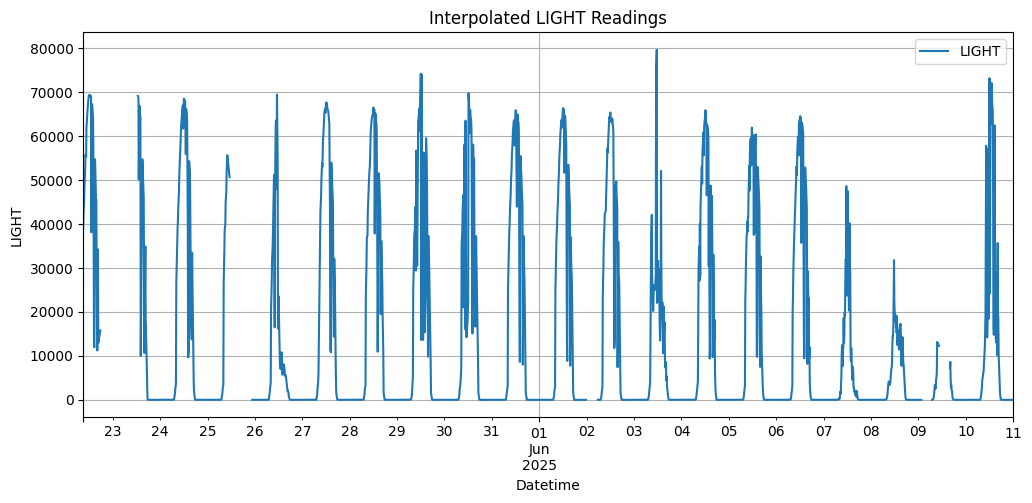

In [66]:
df_interpolated.plot(figsize=(12, 5), title="Interpolated LIGHT Readings")
plt.xlabel("Datetime")
plt.ylabel("LIGHT")
plt.grid(True)
plt.show()

## Inside

In [108]:
data_list = []
# devices_inside = [
#     device for device in devices if device["device_name"] != "Willow Creek Weather"
# ]
for device in devices:
    device_name = device["device_name"]
    logger.info(f"Processing device {device_name}")
    df = import_readings(
        device_name.replace(" ", "_").lower(), type="cleaned"
    )
    df_resample = df.copy(deep=True)
    df_resample.drop(columns=['dt'], inplace=True)
    df_resample = df_resample.resample("10 min").mean()
    df_interpolated = df_resample.interpolate(
        method="time", limit_area="inside", limit=6
    )
    df_interpolated["datetime"] = pd.to_datetime(df_interpolated.index)
    params = {
        "device_name": device_name,
        "start_date": df.index.min(),
        "end_date": df.index.max(),
        "df": df,
        "df_resample": df_resample,
        "df_interpolated": df_interpolated,
    }
    data_list.append(params)

2025-06-17 16:13:11.699 | INFO     | __main__:<module>:7 - Processing device Willow Creek Weather
2025-06-17 16:13:11.700 | INFO     | readings:import_readings:71 - Importing readings from folder: /Users/wspamer/Dev/python/projects/ccr-system/nvirosense/data/readings/cleaned
2025-06-17 16:13:11.701 | INFO     | files:find_file:84 - Found file: willow_creek_weather_2025-06-11.csv for device: willow_creek_weather
2025-06-17 16:13:11.701 | INFO     | readings:import_readings:75 - Importing readings from file: willow_creek_weather_2025-06-11.csv
2025-06-17 16:13:11.709 | INFO     | readings:import_readings:85 - Readings imported successfully from /Users/wspamer/Dev/python/projects/ccr-system/nvirosense/data/readings/cleaned/willow_creek_weather_2025-06-11.csv
2025-06-17 16:13:11.718 | INFO     | __main__:<module>:7 - Processing device Aquanet Light Sensor
2025-06-17 16:13:11.718 | INFO     | readings:import_readings:71 - Importing readings from folder: /Users/wspamer/Dev/python/projects/cc

In [109]:
dates = [x["start_date"] for x in data_list]
dt_start = max(dates)

In [ ]:
dfs_inside = [x["df_interpolated"] for x in data_list if x["device_name"] != "Willow Creek Weather"]
df_inside = pd.concat(dfs_inside, axis=1)
df_inside = df_inside.loc[dt_start:]
df_inside["SOLAR RADIATION"] = df_inside["LIGHT"].apply(lambda x: round(x * 0.0079, 2))
df_inside = df_inside.drop(columns=["WIND DIRECTION", "LIGHT"])

## Outside

In [115]:
device = [
    device for device in devices if device["device_name"] == "Willow Creek Weather"
]

In [116]:
df_outside = [data for data in data_list if data["device_name"] == "Willow Creek Weather"][0]["df_interpolated"]

In [117]:
sensor_list = list(df_inside.columns)
df_outside = df_outside[sensor_list]
df_outside = df_outside.loc[dt_start:]
# df_outside["datetime"] = pd.to_datetime(df_outside.index)

In [95]:
sensor_list

['HUMIDITY', 'TEMPERATURE', 'WIND SPEED', 'SOLAR RADIATION']

## Export

In [118]:
from env import project_path

path_data = os.path.join(project_path, "data", "readings", "final")

df_inside.to_csv(f"{path_data}/Inside.csv", index=False)
df_outside.to_csv(f"{path_data}/Outside.csv", index=False)
logger.info(f"Data saved to {path_data}")

2025-06-17 16:14:16.094 | INFO     | __main__:<module>:7 - Data saved to /Users/wspamer/Dev/python/projects/ccr-system/nvirosense/data/readings/final


## Compare

In [96]:
sensor_name = "TEMPERATURE"

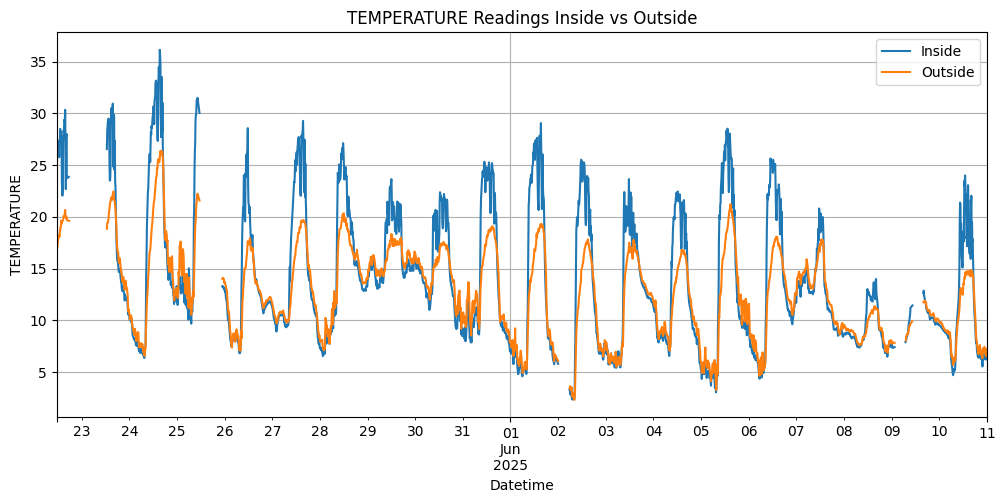

In [97]:
s1 = df_inside[sensor_name]
s2 = df_outside[sensor_name]
df = pd.concat([s1, s2], axis=1)
df.columns = ["Inside", "Outside"]
df.plot(figsize=(12, 5), title=f"{sensor_name} Readings Inside vs Outside")
plt.xlabel("Datetime")
plt.ylabel(sensor_name)
plt.grid(True)
plt.show()